In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from analyze import HistoryEntry

In [3]:
log_dir = 'docker_data/hc_profiler_sweep_correct1/cifar100+shufflenetv2+bs8+adam+lr0.001+tm0.5+me100+eta0.5+beta2.0+2022112711481669567728'
history_file = f'{log_dir}/history.py'

In [4]:
history = eval(open(history_file).read())

In [5]:
def convert_HistoryEntry_to_dict(h_entry):
    dict = {
        'batch_size': h_entry.bs, 
        'learning_rate': h_entry.lr,
        'power_limit': h_entry.pl, 
        'learning_rate_factor': h_entry.factor,
        'energy': h_entry.energy, 
        'time': h_entry.time, 
        'accuracy': h_entry.accuracy,
        'total_cost': h_entry.total_cost
    }
    return dict

In [6]:
history_list = [convert_HistoryEntry_to_dict(he) for he in history]

In [46]:
history_df = pd.DataFrame(history_list)
history_df["cost1"] = history_df.total_cost
history_df.head()

,batch_size,learning_rate,power_limit,learning_rate_factor,energy,time,accuracy,total_cost,cost1
0,8,0.0008,175,0.8,97.069213,2.180381,0.0115,5.158387,5.158387
1,8,0.0008,150,0.8,95.983149,2.242382,0.0101,6.016315,6.016315
2,8,0.0008,125,0.8,96.967632,2.238270,0.0133,4.576969,4.576969
3,8,0.0008,100,0.8,97.486305,2.191365,0.0102,5.854088,5.854088
4,8,0.0010,175,1.0,97.340309,2.227548,0.0122,4.972549,4.972549


In [47]:
# For each (bs, lr) pair, get power limit with min total_cost
# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby
MAXPOWER = 175
ETA = 0.5
history_df["cost2"] = (ETA * history_df.energy + (1 - ETA) * MAXPOWER) * history_df.time/history_df.accuracy
pl100 = history_df[history_df.power_limit == 150]
# cost_idx = history_df.groupby(['batch_size', 'learning_rate_factor'])['total_cost'].transform(min) == history_df['total_cost']
# history_df[cost_idx].head()

In [ ]:
# cost_heatmap_df = history_df[cost_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='total_cost')
# cost_heatmap_df.head()

Text(0.5, 0.98, 'Profiling Energy, Time, Accuracy and Cost for Various Hyperparameters')

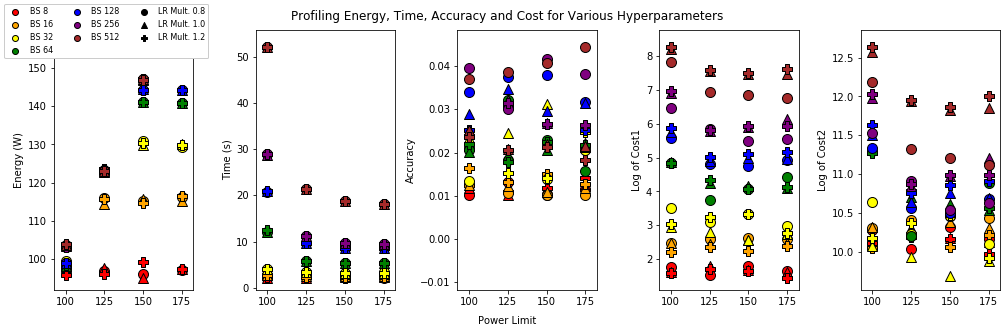

In [68]:
import math

bss = [8, 16, 32, 64, 128, 256, 512]
lr_mults = [0.8, 1.0, 1.2]
pls = [100, 125, 150, 175]

metrics = ["Energy (W)", "Time (s)", "Accuracy", "Cost1", "Cost2"]
colors = ["red", "orange", "yellow", "green", "blue", "purple", "brown"]
markers = ["o", "^", "P"]

fig, axs = plt.subplots(1, 5, figsize=(14, 4.5))
for i in range(len(metrics)):
    for _, row in history_df.iterrows():
        color = colors[bss.index(int(row.batch_size))]
        marker = markers[lr_mults.index(float(row.learning_rate_factor))]
        val = row[metrics[i].split(" ")[0].lower()]
        if "Cost" in metrics[i]:
            val = math.log(val)
        axs[i].scatter(row.power_limit, val, c=color, marker=marker, edgecolor="black", s=100)
    axs[i].set_ylabel(("Log of " if "Cost" in metrics[i] else "") + metrics[i])
    axs[i].set_xticks(range(100, 176, 25), ["100", "125", "150", "175"])

f = lambda m,c: plt.scatter([],[],marker=m, color=c, edgecolor="black")
handles = [f("o", colors[i]) for i in range(len(colors))]
handles += [f(markers[i], "black") for i in range(len(markers))]

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.legend(handles, [f"BS {bs}" for bs in bss] + [f"LR Mult. {lr}" for lr in lr_mults], ncol=3, loc='upper left', framealpha=1, prop={'size': 8})
fig.text(0.5, 0.01, 'Power Limit', ha='center')
fig.suptitle("Profiling Energy, Time, Accuracy and Cost for Various Hyperparameters")

In [ ]:
factor_lr_mapping = history_df.pivot_table(index='batch_size', columns='learning_rate_factor', values='learning_rate')
factor_lr_mapping

# Is it the same with power?

In [ ]:
history_df['avg_power'] = history_df['energy'] / history_df['time']
history_df.head()

In [ ]:
# A bit weird, but we'll pick the (bs, lr) pair with the lowest average power... 
# Note that "energy" is average power
power_idx = history_df.groupby(['batch_size', 'learning_rate_factor'])['energy'].transform(min) == history_df['energy']
history_df[power_idx].head()

In [ ]:
power_heatmap_df = history_df[power_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='energy')
power_heatmap_df.head()

In [ ]:
sns.heatmap(power_heatmap_df, annot=True, fmt='g', cmap=cmap)
plt.title("Avg Power Usage for Different BS, LR")

# How about accuracy?

In [ ]:
history_df['acc_per_time'] = history_df['accuracy']
history_df.head()

In [ ]:
# A bit weird, but we'll pick the (bs, lr) pair with the highest average accuracy rate...??? 
acc_idx = history_df.groupby(['batch_size', 'learning_rate_factor'])['acc_per_time'].transform(max) == history_df['acc_per_time']
history_df[acc_idx].head()

In [ ]:
acc_heatmap_df = history_df[acc_idx].pivot_table(index='batch_size', columns='learning_rate_factor', values='acc_per_time')
acc_heatmap_df.head()

In [ ]:
sns.heatmap(history_df.pivot_table(index='batch_size', columns='learning_rate_factor', values='accuracy'), annot=True, fmt='g')
plt.title('Profiling Accuracy for Different BS, LR')
plt.show()

In [ ]:
sns.heatmap(history_df.pivot_table(index='batch_size', columns='learning_rate_factor', values='time'), annot=True, fmt='g')
plt.title('Profiling Time for Different BS, LR')
plt.show()